In [1]:
import sys 
sys.path.append("../tf_tabnet/")

import warnings

import pandas as pd
import tensorflow as tf

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import tabnet_model

In [2]:
train_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
test_data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"
feature_names = ["age", "workclass", "fnlwgt", "education", "education-num", 
                 "marital-status", "occupation", "relationship", "race", "sex",
                 "capital-gain", "capital-loss", "hours-per-week", 
                 "native-country", "income"]

In [3]:
train_data = pd.read_csv(train_data_url, 
                         sep=",", 
                         skipinitialspace=True, 
                         na_values="?", 
                         names=feature_names)

test_data = pd.read_csv(test_data_url, 
                        sep=",", 
                        skiprows=1, 
                        skipinitialspace=True, 
                        na_values="?", 
                        names=feature_names)

In [4]:
val_data = train_data.sample(frac=0.2, random_state=1234)
train_data = train_data.drop(val_data.index)

In [5]:
print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

Train shape: (26049, 15)
Validation shape: (6512, 15)
Test shape: (16281, 15)


In [6]:
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [7]:
print("Train: missing values")
print(train_data.isnull().sum())
print("\nVal: missing values")
print(val_data.isnull().sum())
print("\nTest: missing values")
print(test_data.isnull().sum())

Train: missing values
age                  0
workclass         1456
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1461
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     463
income               0
dtype: int64

Val: missing values
age                 0
workclass         380
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        382
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    120
income              0
dtype: int64

Test: missing values
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain  

In [8]:
def impute_missing_with_mode(dataframe, columns):
    for col in columns:
        dataframe[col].fillna(dataframe[col].mode()[0], inplace=True)

In [9]:
columns_with_missing = ['workclass', 'occupation', 'native-country']

impute_missing_with_mode(train_data, columns_with_missing)
impute_missing_with_mode(val_data, columns_with_missing)
impute_missing_with_mode(test_data, columns_with_missing)

In [10]:
print("Train: missing values")
print(train_data.isnull().sum())
print("\nVal: missing values")
print(val_data.isnull().sum())
print("\nTest: missing values")
print(test_data.isnull().sum())

Train: missing values
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Val: missing values
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

Test: missing values
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: in

In [11]:
train_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

In [12]:
# Converting target variable into int encoded {0,1} variable
train_data["income"] = train_data["income"].astype("category").cat.codes
val_data["income"] = val_data["income"].astype("category").cat.codes
test_data["income"] = test_data["income"].astype("category").cat.codes

In [13]:
train_data.nunique()

age                  73
workclass             8
fnlwgt            18359
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        117
capital-loss         88
hours-per-week       94
native-country       40
income                2
dtype: int64

In [14]:
def dataframe_to_tf_dataset(dataframe:pd.DataFrame, target_name: str):
    dataframe = dataframe.copy()
    labels = dataframe.pop(target_name)
    ds = tf.data.Dataset.from_tensor_slices(
        (dict(dataframe), labels)
    )
    return ds

In [15]:
train_ds = dataframe_to_tf_dataset(train_data, "income")
val_ds = dataframe_to_tf_dataset(test_data, "income")
test_ds = dataframe_to_tf_dataset(test_data, "income")

In [16]:
# splitting data into batches
batch_size = 4_096

train_ds = train_ds.shuffle(16_384, seed=1234).batch(batch_size).prefetch(1)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

In [17]:
# The first TF record
for x, y in train_ds.unbatch().take(1):
    print(f"X: {x}")
    print(f"y: {y}")
    print(f"Age: {x['age']}")

X: {'age': <tf.Tensor: shape=(), dtype=int64, numpy=64>, 'workclass': <tf.Tensor: shape=(), dtype=string, numpy=b'Private'>, 'fnlwgt': <tf.Tensor: shape=(), dtype=int64, numpy=91343>, 'education': <tf.Tensor: shape=(), dtype=string, numpy=b'Some-college'>, 'education-num': <tf.Tensor: shape=(), dtype=int64, numpy=10>, 'marital-status': <tf.Tensor: shape=(), dtype=string, numpy=b'Widowed'>, 'occupation': <tf.Tensor: shape=(), dtype=string, numpy=b'Tech-support'>, 'relationship': <tf.Tensor: shape=(), dtype=string, numpy=b'Unmarried'>, 'race': <tf.Tensor: shape=(), dtype=string, numpy=b'White'>, 'sex': <tf.Tensor: shape=(), dtype=string, numpy=b'Female'>, 'capital-gain': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'capital-loss': <tf.Tensor: shape=(), dtype=int64, numpy=0>, 'hours-per-week': <tf.Tensor: shape=(), dtype=int64, numpy=40>, 'native-country': <tf.Tensor: shape=(), dtype=string, numpy=b'United-States'>}
y: 0
Age: 64


In [18]:
# all features sans the target
feature_names.remove("income")

# list of categorical features represented as string
cat_str_feature_names = list(train_data.select_dtypes(include=["object"]).columns)

# list of categorical features represented as int (note: none in this dataset)
cat_int_feature_names = list()

# dimension of the embedding layer for categorical variables
cat_embed_dims = {
    "workclass": 3, 
    "education": 5, 
    "marital-status": 3, 
    "occupation": 3, 
    "relationship": 3, 
    "race": 3, 
    "sex": 1, 
    "native-country": 5, 
}

In [19]:
def create_keras_input_layer(feature_names, cat_str_feature_names, cat_int_feature_names):
    model_inputs = list()
    
    for name in feature_names:
        if name in cat_str_feature_names:
            dtype = tf.string
        elif name in cat_int_feature_names:
            dtype = tf.int64
        else:
            dtype = tf.float32
        
        shape = (1,) if dtype==tf.float32 else ()
        model_inputs.append(tf.keras.Input(shape=shape, name=name, dtype=dtype))
    
    return model_inputs

In [20]:
def encode_categorical_feature(keras_input, feature_name, dataset, 
                               embed_dim, is_string):
    feature_ds = dataset.map(lambda x, _: x[feature_name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    lookup_fn = tf.keras.layers.StringLookup if is_string else tf.keras.layers.IntegerLookup
    lookup = lookup_fn(output_mode="int")
    lookup.adapt(feature_ds)
    encoded_feature = lookup(keras_input)
    embedded_feature = tf.keras.layers.Embedding(
        input_dim=lookup.vocabulary_size(), 
        output_dim=embed_dim, 
        name=f"{feature_name}_embedding"
    )(encoded_feature)

    return embedded_feature


def encode_features(keras_inputs, feature_names, 
                    cat_str_feature_names, cat_int_feature_names, cat_embed_dims, 
                    dataset):
    encoded_features = list()

    for keras_input, feature_name in zip(keras_inputs, feature_names):
        if feature_name in cat_str_feature_names or feature_name in cat_int_feature_names:
            # add embedding layer for all categorical features
            embed_dim = cat_embed_dims[feature_name] if feature_name in cat_embed_dims.keys() else 1
            encoded_features.append(
                encode_categorical_feature(keras_input, feature_name, 
                                           dataset, 
                                           embed_dim, 
                                           feature_name in cat_str_feature_names)
            )
        else: 
            # no encoding for numerical features
            encoded_features.append(keras_input)
    
    return encoded_features

In [21]:
tabnet_params = {
        "decision_dim": 16, 
        "attention_dim": 16, 
        "n_steps": 5, 
        "n_shared_glus": 2, 
        "n_dependent_glus": 2, 
        "relaxation_factor": 1.5, 
        "epsilon": 1e-15, 
        "virtual_batch_size": None, 
        "momentum": 0.98, 
        "mask_type": "entmax", 
        "lambda_sparse": 1e-4, 
}

In [22]:
# Keras model using Functional API
inputs = create_keras_input_layer(feature_names, 
                                  cat_str_feature_names, 
                                  cat_int_feature_names)
x = encode_features(inputs, feature_names, 
                    cat_str_feature_names, cat_int_feature_names, cat_embed_dims, 
                    train_ds)
x = tf.keras.layers.Concatenate()(x)
x = tabnet_model.TabNetEncoder(**tabnet_params)(x)
output = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs, output)

In [23]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=["accuracy"])

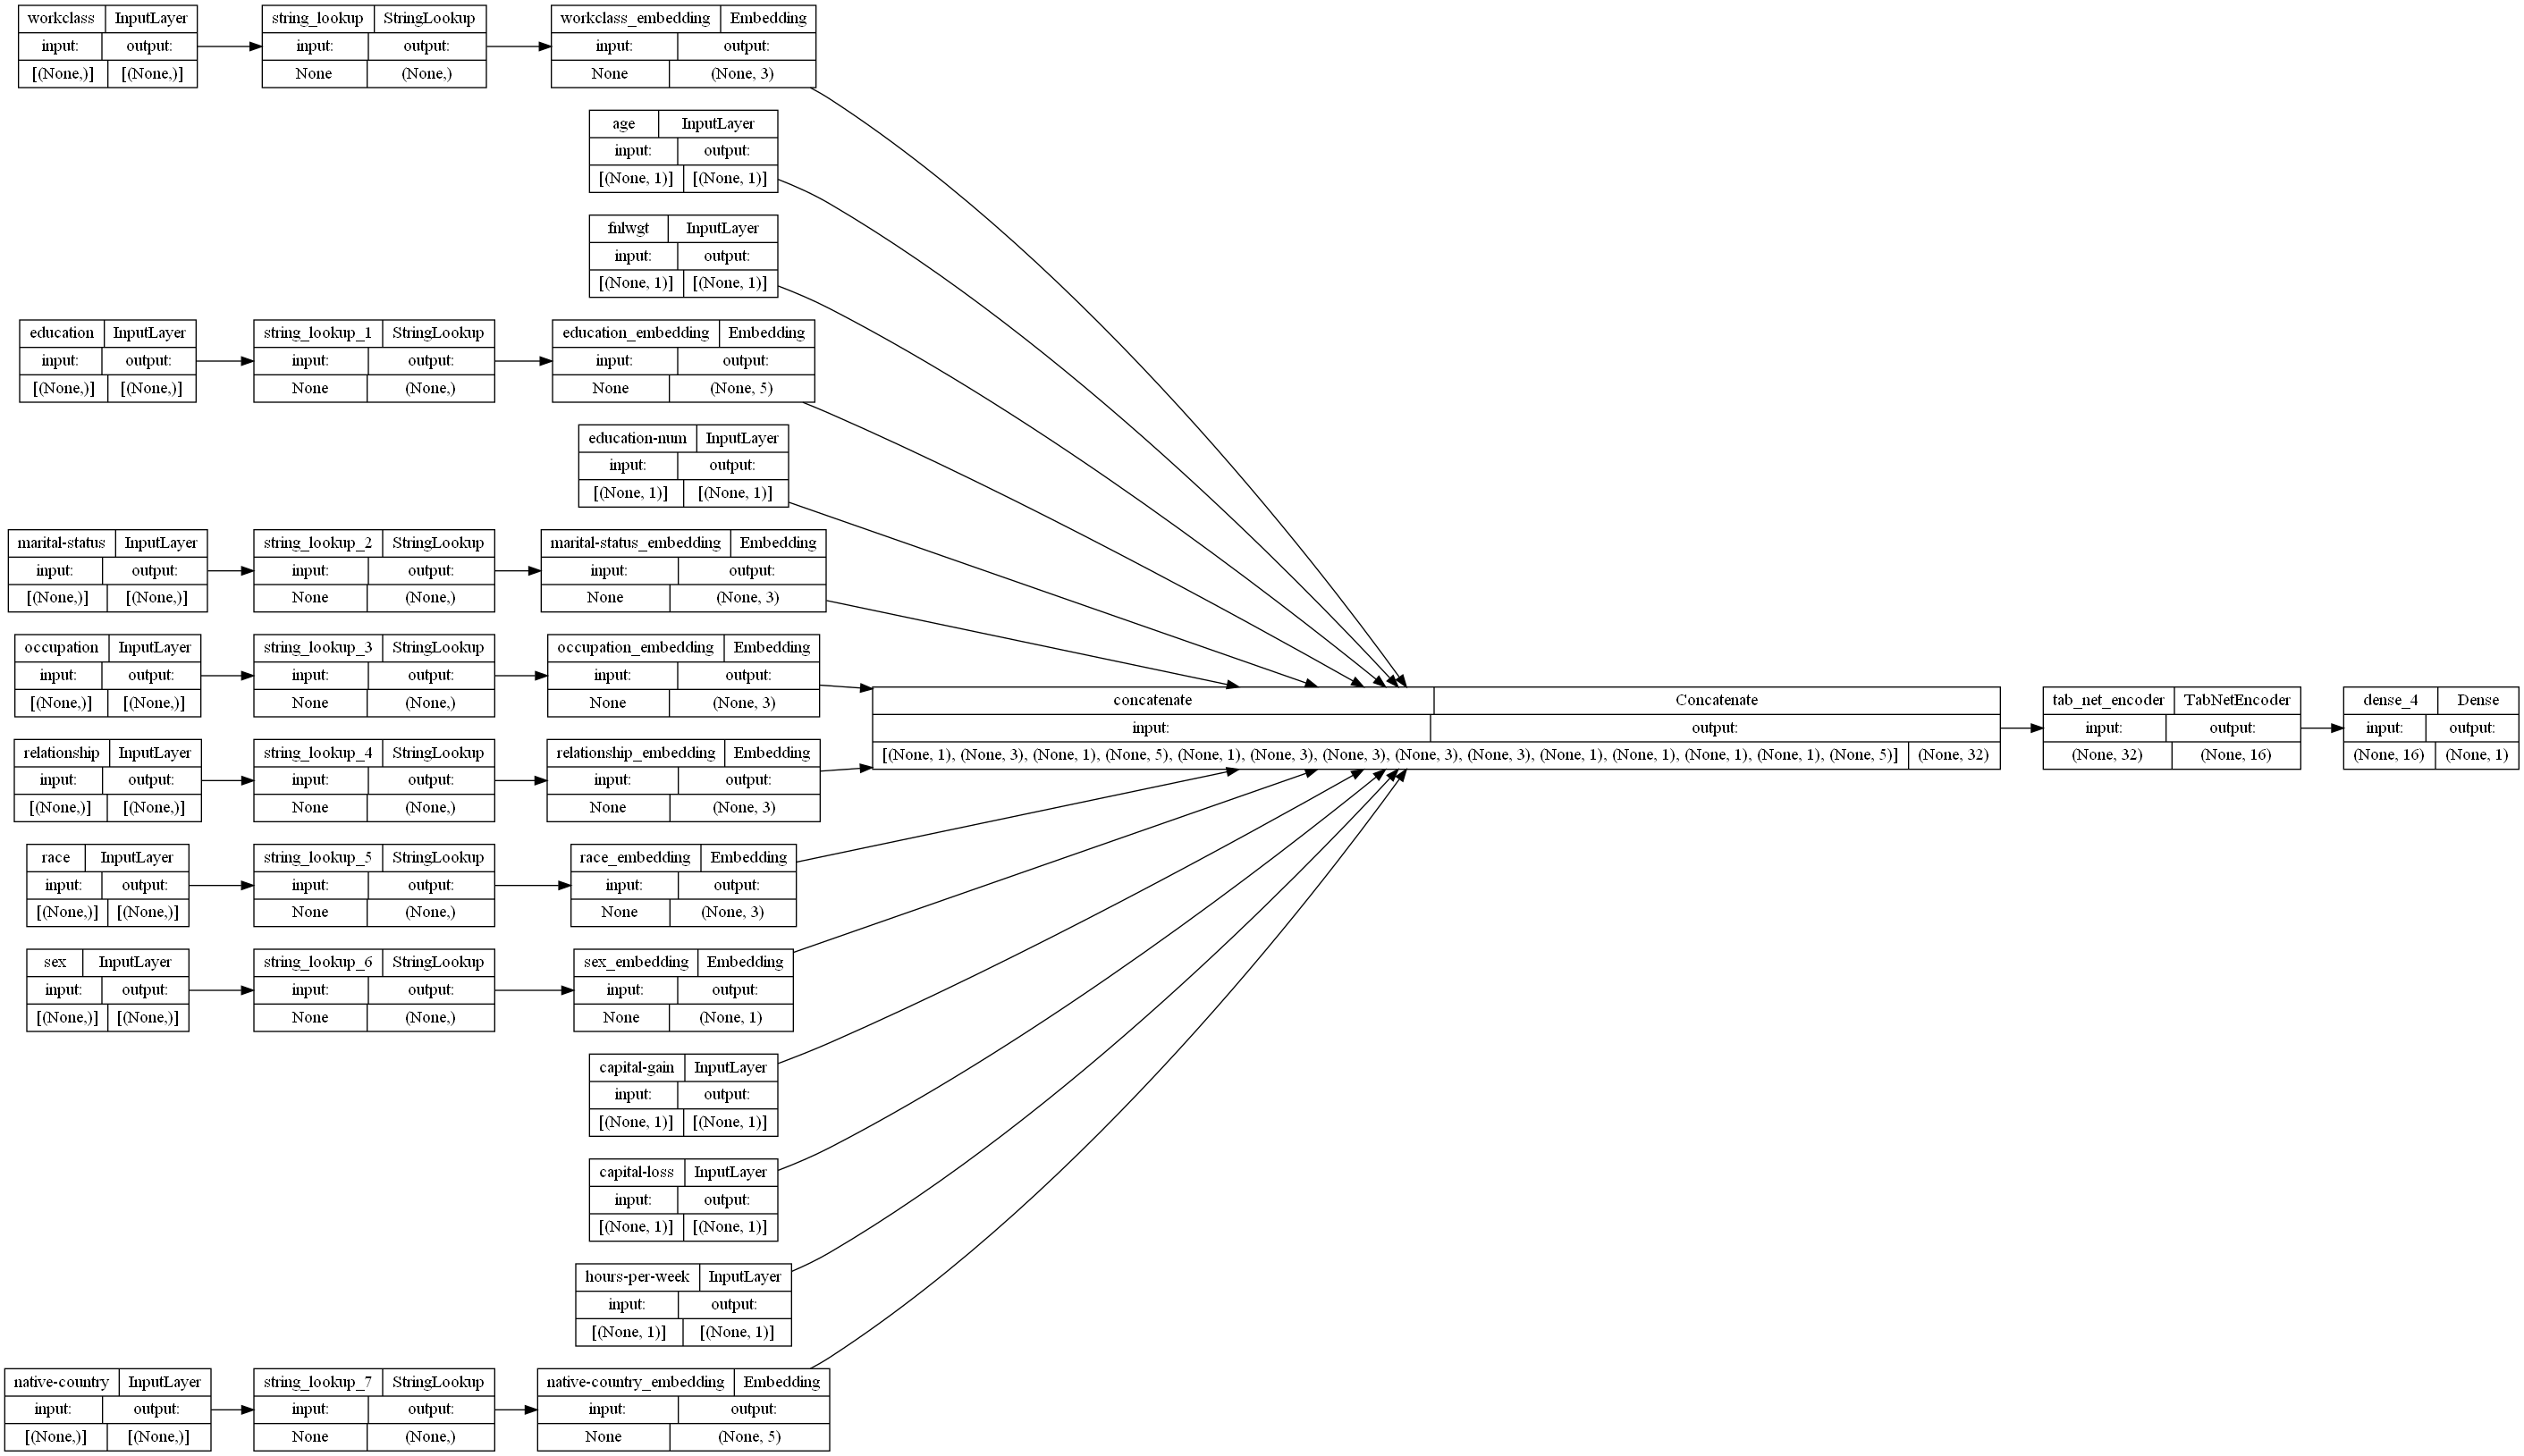

In [24]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 workclass (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 education (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 marital-status (InputLayer)    [(None,)]            0           []                               
                                                                                                  
 occupation (InputLayer)        [(None,)]            0           []                               
                                                                                              

In [26]:
callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                            patience=10, 
                                            restore_best_weights=True)]

model.fit(train_ds, 
          validation_data=val_ds, 
          epochs=100, 
          callbacks=callbacks, 
          verbose=1)

Epoch 1/100
7/7 [==============================] - 15s 745ms/step - loss: 0.6491 - accuracy: 0.7343 - val_loss: 0.7179 - val_accuracy: 0.7638
Epoch 2/100
7/7 [==============================] - 4s 520ms/step - loss: 0.5437 - accuracy: 0.7618 - val_loss: 0.6816 - val_accuracy: 0.7638
Epoch 3/100
7/7 [==============================] - 4s 525ms/step - loss: 0.4965 - accuracy: 0.7657 - val_loss: 0.6593 - val_accuracy: 0.7638
Epoch 4/100
7/7 [==============================] - 4s 522ms/step - loss: 0.4660 - accuracy: 0.7768 - val_loss: 0.6438 - val_accuracy: 0.7638
Epoch 5/100
7/7 [==============================] - 4s 520ms/step - loss: 0.4417 - accuracy: 0.7935 - val_loss: 0.6321 - val_accuracy: 0.7638
Epoch 6/100
7/7 [==============================] - 4s 522ms/step - loss: 0.4273 - accuracy: 0.7991 - val_loss: 0.6230 - val_accuracy: 0.7638
Epoch 7/100
7/7 [==============================] - 4s 534ms/step - loss: 0.4113 - accuracy: 0.8087 - val_loss: 0.6143 - val_accuracy: 0.7638
Epoch 8/100


In [27]:
model.evaluate(test_ds)

4/4 [==============================] - 1s 311ms/step - loss: 0.3342 - accuracy: 0.8397


[0.33424559235572815, 0.8396904468536377]

In [28]:
def probabilistic_model(model, inputs):
    out = tf.keras.layers.Activation("sigmoid")(model.layers[-1].output)
    return tf.keras.Model(inputs, out)

In [29]:
prob_model = probabilistic_model(model, inputs)

In [30]:
sample = {
    "age": 39, 
    "workclass": "Private", 
    "fnlwgt": 198654, 
    "education": "Prof-school", 
    "education-num": 15, 
    "marital-status": "Married-civ-spouse", 
    "occupation": "Prof-specialty", 
    "relationship": "Husband", 
    "race": "Asian-Pac-Islander", 
    "sex": "Male",
    "capital-gain": 0, 
    "capital-loss": 2415, 
    "hours-per-week": 67, 
    "native-country": "India",
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)
print(f"The probability that the individual earns >50K is {prob_model.predict(input_dict)[0][0]:.2f}")

1/1 [==============================] - 1s 1s/step
The probability that the individual earns >50K is 0.78
